In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from typing import List

from user import User

## Base user parameters

In [3]:
num_iterations = 1200

# Transitions for EC
ec_base = np.array([
    [0.4, 0.2, 0.05, 0.2, 0.1, 0.05],
    [0.025, 0.6, 0.025, 0.025, 0.3 ,0.025],
    [0.05, 0.2, 0.4, 0.05, 0.1, 0.2],
    [0.025, 0.025, 0.025, 0.6, 0.3, 0.025],
    [0, 0, 0, 0, 1, 0],
    [0.025, 0.025, 0.025, 0.025, 0.3, 0.6]
])

# Transitions for EA
ea_base = np.array([
    [0.9, 0.02, 0.02, 0.02, 0.02, 0.02],
    [0.02, 0.9, 0.02, 0.02, 0.02, 0.02],
    [0.02, 0.02, 0.9, 0.02, 0.02, 0.02],
    [0.02, 0.02, 0.02, 0.9, 0.02, 0.02],
    [0, 0, 0, 0, 1, 0],
    [0.02, 0.02, 0.02, 0.02, 0.02, 0.9]
])

# Transitions for DO NOTHING
do_nothing_base = np.array([
    [250, 15, 5, 15 ,5, 1],
    [15, 250, 15, 5, 15, 5],
    [5, 15, 250, 1, 5, 15],
    [15, 5, 1, 250, 15, 5],
    [5, 15, 5, 15, 250, 15],
    [1, 5, 15, 5, 15, 250],
])
do_nothing_base = do_nothing_base / np.sum(do_nothing_base, axis=1)[:, np.newaxis]

base_transition_matrix = np.array([ec_base, ea_base, do_nothing_base])

lambda_range = (1e-4, -np.log(5/7)/num_iterations)
p_aha_range = (0.1, 0.2)
p_aha_factor_range = (1, 2.5 ** (10/num_iterations))
posture_change_factor_range = (0.815, 1) # The range for the factor by which the probability of staying in the same state decreases


## Simulating a single user

In [4]:
user: User = User.generate_users(base_transition_matrix, lambda_range, p_aha_range, p_aha_factor_range, posture_change_factor_range, num_users=1)[0]
print(f"Lambda {user._lambda} | p_aha {user._p_aha} \np_aha_factor {user._p_aha_factor} | posture_change_factor {user._posture_change_factor}\n")

Lambda 0.00018399056612549165 | p_aha [0.10088257 0.17730251 0.10797398 0.19541396 0.15255828 0.1098629 ] 
p_aha_factor 1.0035950663144986 | posture_change_factor 0.8616973991256661



### Q-learning

In [5]:
# Q-learning
subopts, average_rewards, cum_rewards, idxs = user.simulation("Q", num_iterations=num_iterations, explore_rate=0.1, t_timeout=7)

print("Q values:")
print(user._agent_q._Q)
print()

print("Optimal_actions:")
print(user.optimal_actions(user._agent_q._Q))
print()

Q values:
[[ 0.45143559  0.58954414]
 [ 0.82893187  0.18993512]
 [ 0.78417361 -0.33461456]
 [ 0.86304709  0.39847646]
 [ 0.          0.        ]
 [ 0.84373178  0.18787059]]

Optimal_actions:
[['EA' 'EC' 'EC']
 ['EC' 'EC' 'EC']]



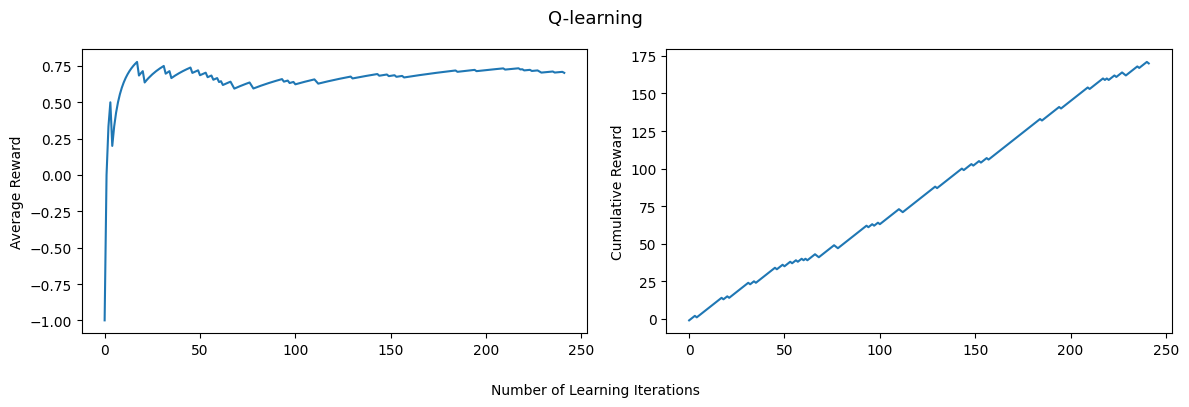

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot average_rewards
axs[0].plot(average_rewards)
axs[0].set_ylabel('Average Reward')

# Plot cum_rewards
axs[1].plot(cum_rewards)
axs[1].set_ylabel('Cumulative Reward')

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('Q-learning', fontsize=13)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Value function suboptimalities')

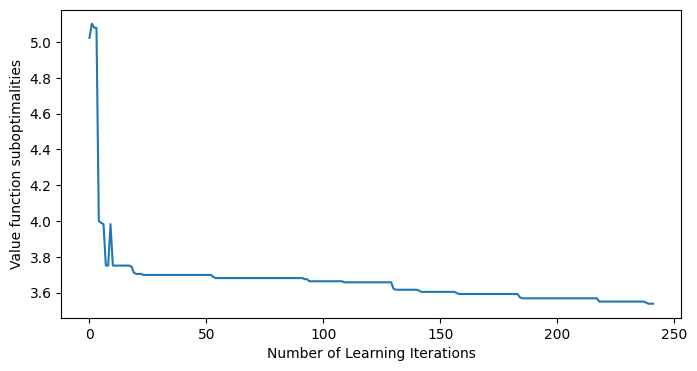

In [7]:
fig = plt.figure(figsize=(8, 4))
plt.plot(subopts)
plt.xlabel("Number of Learning Iterations")
plt.ylabel("Value function suboptimalities")

### SARSA

In [8]:
# SARSA
subopts, average_rewards, cum_rewards, idxs = user.simulation("SARSA", num_iterations=num_iterations, explore_rate=0.1, t_timeout=7)

print("Q values:")
print(user._agent_sarsa._Q)
print()

print("Optimal_actions:")
print(user.optimal_actions(user._agent_sarsa._Q))
print()

Q values:
[[ 0.80050447  0.43443749]
 [ 0.87024707  0.72504425]
 [ 0.60706002 -0.03704714]
 [ 0.91106599  0.80495054]
 [ 0.          0.        ]
 [ 0.84396941  0.76248767]]

Optimal_actions:
[['EC' 'EC' 'EC']
 ['EC' 'EC' 'EC']]



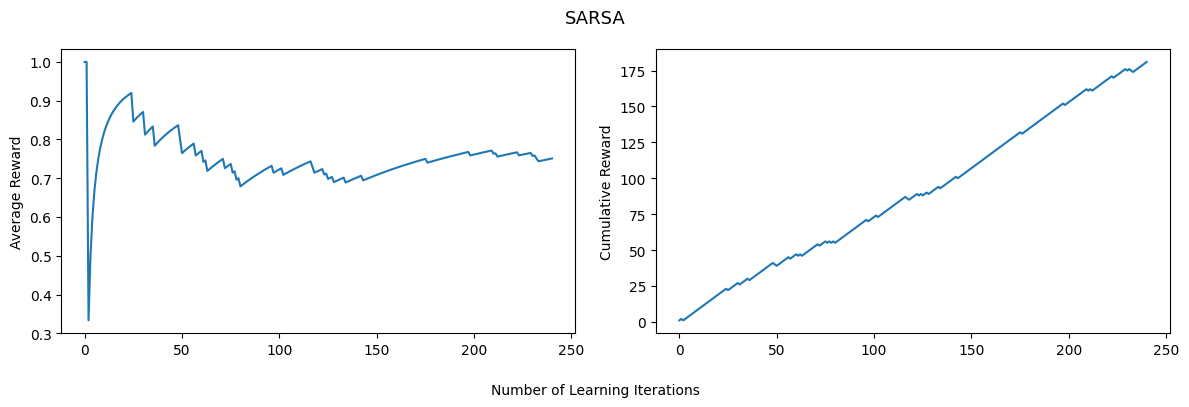

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot average_rewards
axs[0].plot(average_rewards)
axs[0].set_ylabel('Average Reward')

# Plot cum_rewards
axs[1].plot(cum_rewards)
axs[1].set_ylabel('Cumulative Reward')

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('SARSA', fontsize=13)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Value function suboptimalities')

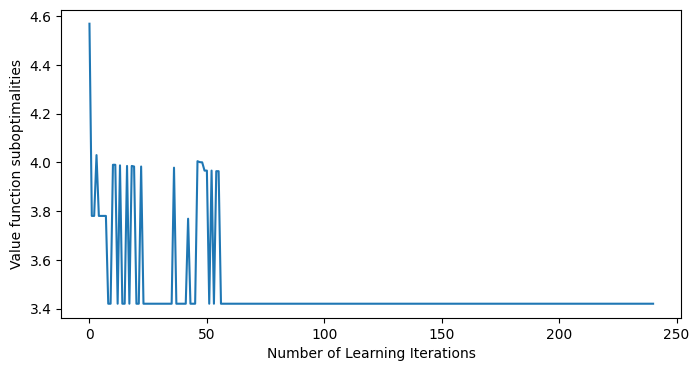

In [10]:
fig = plt.figure(figsize=(8, 4))
plt.plot(subopts)
plt.xlabel("Number of Learning Iterations")
plt.ylabel("Value function suboptimalities")

## Simulating on multiple users

In [11]:
num_users = 10
users: List[User] = User.generate_users(base_transition_matrix, lambda_range, p_aha_range, p_aha_factor_range, posture_change_factor_range, num_users=num_users)

### Q-learning

In [12]:
Qs = []
average_rewards = []
cum_rewards = []
subopts = []

for user in users:
    subs, avg_rewards, c_rewards, _ = user.simulation("Q", num_iterations=num_iterations, explore_rate=0.1, t_timeout=7)
    Qs.append(user._agent_q._Q)
    average_rewards.append(avg_rewards)
    cum_rewards.append(c_rewards)
    subopts.append(subs)

subopts = [np.array(sub) for sub in subopts]

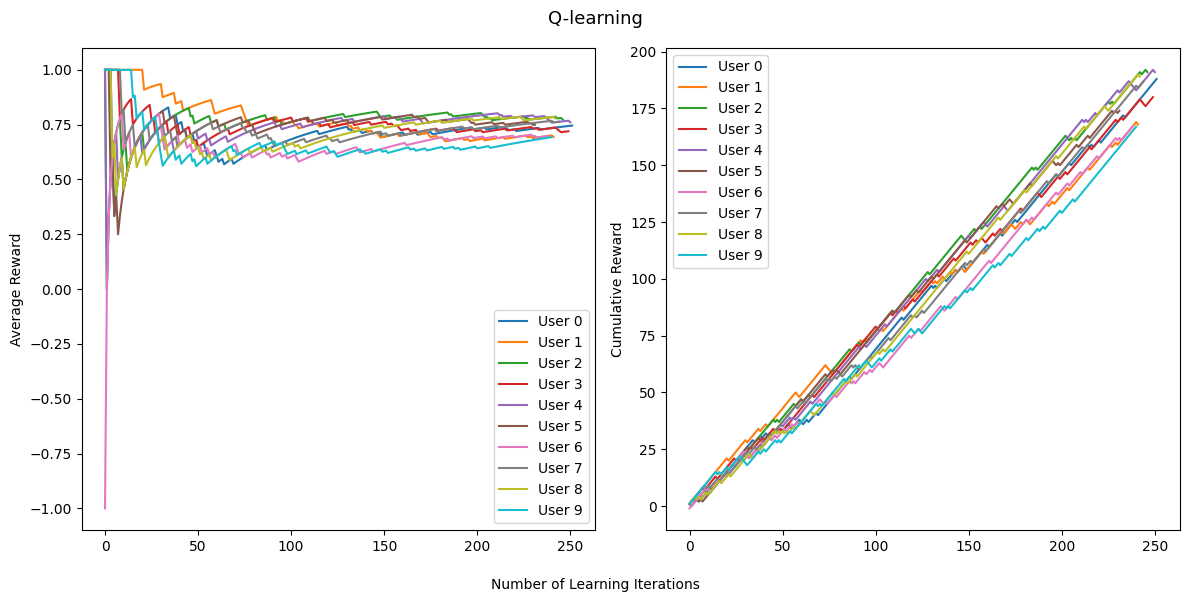

In [13]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot average reward for each user
for idx in range(num_users):
    axs[0].plot(average_rewards[idx], label=f"User {idx}")
    axs[1].plot(cum_rewards[idx], label=f"User {idx}")

axs[0].set_ylabel("Average Reward")
axs[0].legend()

axs[1].set_ylabel("Cumulative Reward")
axs[1].legend()

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('Q-learning', fontsize=13)

plt.tight_layout()
plt.show()

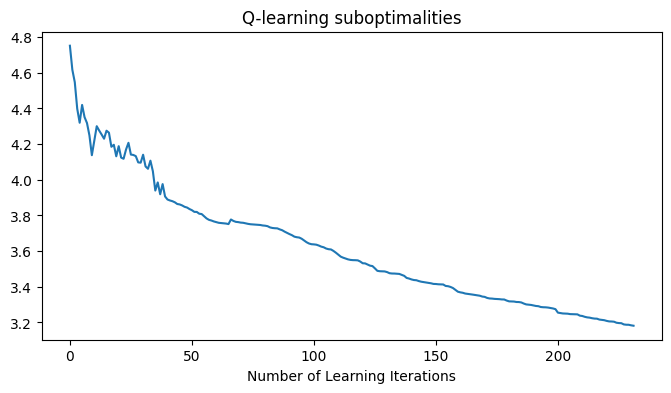

In [14]:
min_len = min([len(sub) for sub in subopts])
subopts_trunc = [sub[:min_len] for sub in subopts]
subopts_mean = sum(subopts_trunc) / num_users

fig = plt.figure(figsize=(8, 4))
plt.title('Q-learning suboptimalities')
plt.xlabel('Number of Learning Iterations')
plt.plot(subopts_mean)

### SARSA

In [15]:
Qs = []
average_rewards = []
cum_rewards = []
subopts = []

for user in users:
    subs, avg_rewards, c_rewards, _ = user.simulation("SARSA", num_iterations=num_iterations, explore_rate=0.1, t_timeout=7)
    Qs.append(user._agent_sarsa._Q)
    average_rewards.append(avg_rewards)
    cum_rewards.append(c_rewards)
    subopts.append(subs)

subopts = [np.array(sub) for sub in subopts]

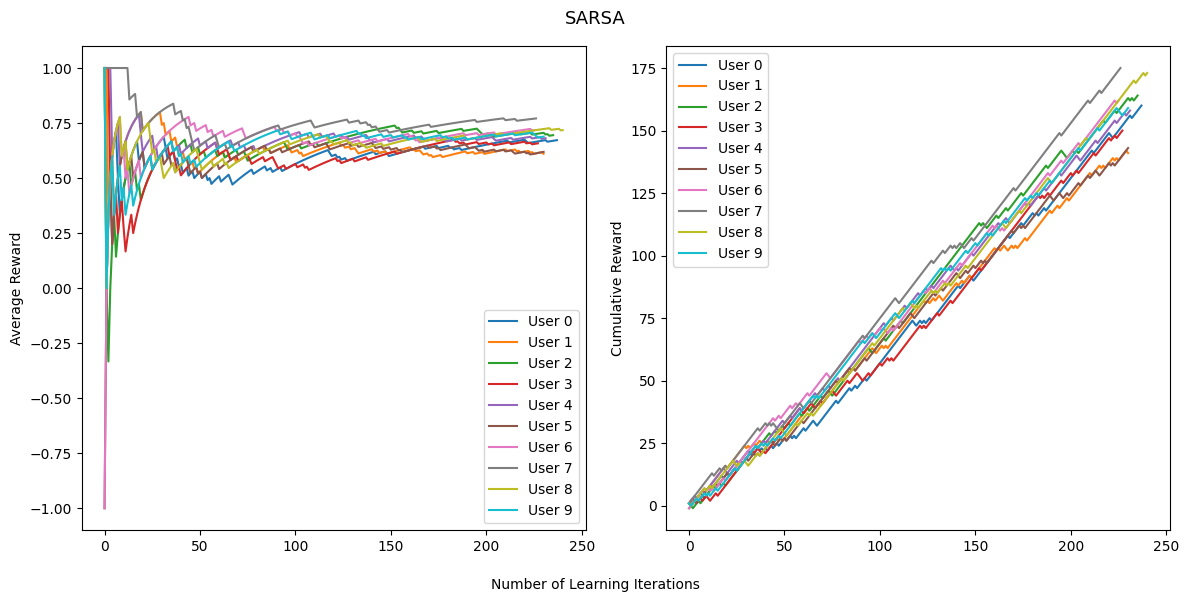

In [16]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot average reward for each user
for idx in range(num_users):
    axs[0].plot(average_rewards[idx], label=f"User {idx}")
    axs[1].plot(cum_rewards[idx], label=f"User {idx}")

axs[0].set_ylabel("Average Reward")
axs[0].legend()

axs[1].set_ylabel("Cumulative Reward")
axs[1].legend()

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('SARSA', fontsize=13)

plt.tight_layout()
plt.show()

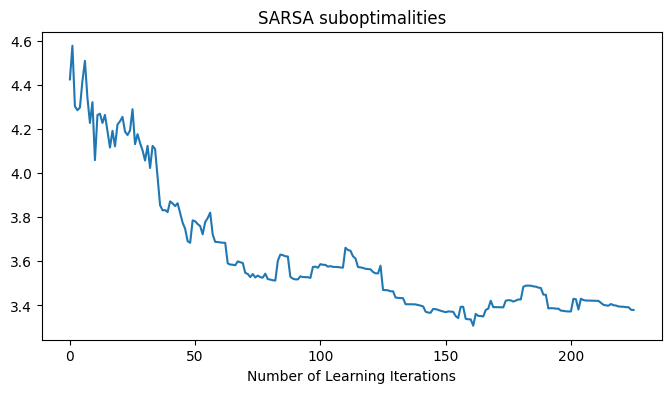

In [17]:
min_len = min([len(sub) for sub in subopts])
subopts_trunc = [sub[:min_len] for sub in subopts]
subopts_mean = sum(subopts_trunc) / num_users

fig = plt.figure(figsize=(8, 4))
plt.title('SARSA suboptimalities')
plt.xlabel('Number of Learning Iterations')
plt.plot(subopts_mean)